In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
# Set plot style for nicer visuals
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

In [2]:
# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X_df = bank_marketing.data.features
y_df = bank_marketing.data.targets
df = pd.concat([X_df, y_df], axis=1)
df['y'] = df['y'].map({'yes': 1, 'no': 0})

检查数据的空缺值情况，发现空缺值都是类别变量。

对于此类变量使用unknown填充，能够不丢失和混淆类别信息

In [3]:
print(df.isnull().sum())

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64


In [4]:
# 需要处理缺失值的列
columns_with_nan = ['job', 'education', 'contact', 'poutcome']

# 对于这些特定的类别列，将 NaN 填充为 "unknown"
for col in columns_with_nan:
    if df[col].isnull().any(): # 检查该列是否确实存在缺失值
        print(f"正在将列 '{col}' 中的 NaN 填充为 'unknown'...")
        df[col] = df[col].fillna("unknown")

正在将列 'job' 中的 NaN 填充为 'unknown'...
正在将列 'education' 中的 NaN 填充为 'unknown'...
正在将列 'contact' 中的 NaN 填充为 'unknown'...
正在将列 'poutcome' 中的 NaN 填充为 'unknown'...


In [5]:
# 识别类别特征和数值特征
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('y') # 从数值特征中移除目标变量
print("类别特征：", categorical_features
      ,"\n数值特征：", numerical_features)

类别特征： ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'] 
数值特征： ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']


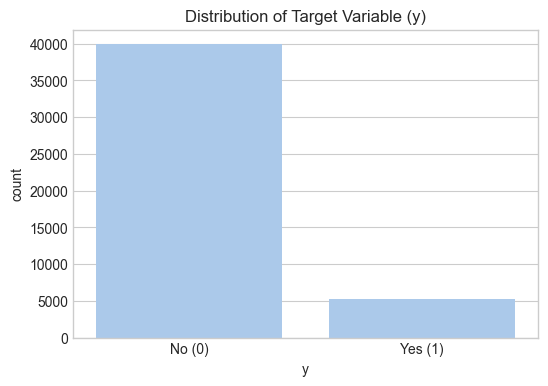

y
0    0.883015
1    0.116985
Name: proportion, dtype: float64


In [6]:
# 目标变量的分布
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df)
plt.title('Distribution of Target Variable (y)') # 英文标题
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
plt.show()
print(df['y'].value_counts(normalize=True)) # 打印目标变量各类别的占比

- 当前图说明数据类别严重不均衡，后续模型acc可能产生误导。同时我们需要对类别不均衡用一些方法处理

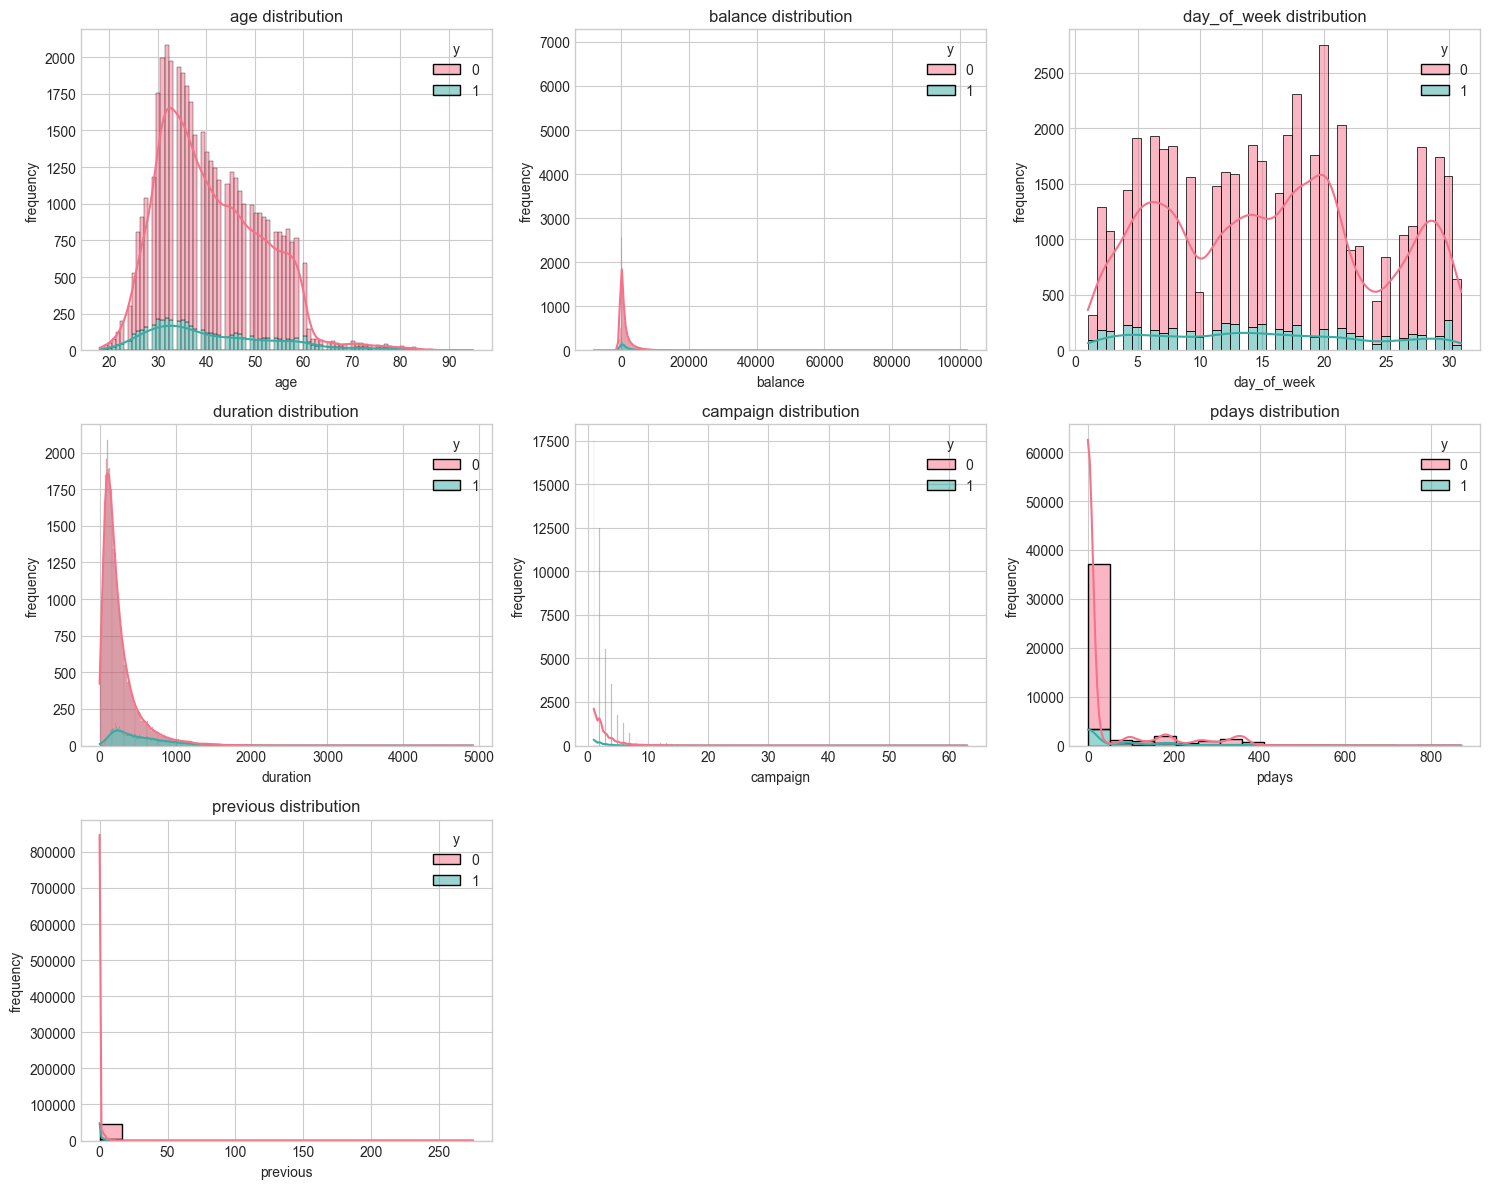

In [7]:
# 对于数值特征，绘制分布图，创建一个3列的画布依次排列
num_features = len(numerical_features)
num_rows = (num_features + 2) // 3  # 向上取整，确保有足够的行

# 创建子图
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
axes = axes.flatten()  # 将多维数组展平为一维

# 为每个数值特征绘制分布图
for i, feature in enumerate(numerical_features):
    ax = axes[i]
    # 绘制直方图和密度图
    sns.histplot(data=df,x=feature, hue='y',kde=True, ax=ax ,multiple="stack",palette="husl")
    ax.set_title(f'{feature} distribution')
    ax.set_xlabel(feature)
    ax.set_ylabel('frequency')

# 隐藏未使用的子图
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()




- balance（余额）：分布特征：严重右偏，大多数值接近0，少数样本有较高余额
- duration（通话时长）分布特征：极度右偏，大部分通话较短
- campaign（营销活动次数）分布特征：右偏，大部分为低次数接触
- pdays（上次联系间隔天数）分布特征：极度右偏，大部分集中在非常低的值
- previous（之前营销活动联系次数）分布特征：大部分值为0，极度右偏


对于'duration', 'campaign',  'previous'等都>0的数值我们直接使用log变换

对于'balance','pdays'存在负值，例如balance负债为负，同时pdays=-1代表为联系过需要额外处理 

In [8]:
log_cols = [ 'duration', 'campaign',  'previous']
# 对每列进行对数变换
for col in log_cols:
    df[col] = np.log1p(df[col])

In [9]:
min_pdays = df['pdays'].min()
min_balance = df['balance'].min()
print(f"原始 'pdays' 最小值: {min_pdays}")
print(f"原始 'balance' 最小值: {min_balance}")

原始 'pdays' 最小值: -1
原始 'balance' 最小值: -8019


In [10]:
#创建符号变量，没联系过是0，联系过是1
df['pdays_was_contacted'] = (df['pdays'] != -1).astype(int)
df['pdays_was_contacted'] = df['pdays_was_contacted'].astype('category')
df['pdays_log1p'] = df['pdays'].copy() # 先复制
df.loc[df['pdays_log1p'] == -1, 'pdays_log1p'] = 0 # 将-1映射到0，因为log1p(0)=0
df['pdays_log1p'] = np.log1p(df['pdays_log1p'])
print("\n对 'pdays' >= 0 (或 -1映射为0后) 的部分进行 log1p 变换，存为 'pdays_log1p':")
print(df[['pdays', 'pdays_was_contacted', 'pdays_log1p']].head(10))
print(f"'pdays_log1p' 描述:\n{df['pdays_log1p'].describe()}")






对 'pdays' >= 0 (或 -1映射为0后) 的部分进行 log1p 变换，存为 'pdays_log1p':
   pdays pdays_was_contacted  pdays_log1p
0     -1                   0          0.0
1     -1                   0          0.0
2     -1                   0          0.0
3     -1                   0          0.0
4     -1                   0          0.0
5     -1                   0          0.0
6     -1                   0          0.0
7     -1                   0          0.0
8     -1                   0          0.0
9     -1                   0          0.0
'pdays_log1p' 描述:
count    45211.000000
mean         0.956843
std          2.047562
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          6.770789
Name: pdays_log1p, dtype: float64


In [11]:
# 1. 创建 'balance_sign' 特征
df['balance_sign'] = np.sign(df['balance'])
# 可以进一步映射为类别: {-1: 'negative', 0: 'zero', 1: 'positive'}
df['balance_sign_category'] = df['balance_sign'].map({-1: 'negative', 0: 'zero', 1: 'positive'}).astype('category')
print("\n创建 'balance_sign' 和 'balance_sign_category' 特征:")
print(df[['balance', 'balance_sign', 'balance_sign_category']].head())

# 2. 对 'balance' 的绝对值进行 log1p 变换
df['balance_log_abs_p1'] = np.log1p(np.abs(df['balance']))
print("\n对 'balance' 的绝对值进行 log1p 变换，存为 'balance_log_abs_p1':")
print(df[['balance', 'balance_log_abs_p1']].head())
print(f"'balance_log_abs_p1' 描述:\n{df['balance_log_abs_p1'].describe()}")



创建 'balance_sign' 和 'balance_sign_category' 特征:
   balance  balance_sign balance_sign_category
0     2143             1              positive
1       29             1              positive
2        2             1              positive
3     1506             1              positive
4        1             1              positive

对 'balance' 的绝对值进行 log1p 变换，存为 'balance_log_abs_p1':
   balance  balance_log_abs_p1
0     2143            7.670429
1       29            3.401197
2        2            1.098612
3     1506            7.317876
4        1            0.693147
'balance_log_abs_p1' 描述:
count    45211.000000
mean         5.745367
std          2.317895
min          0.000000
25%          4.927254
50%          6.186209
75%          7.270313
max         11.533982
Name: balance_log_abs_p1, dtype: float64


In [12]:
selected_features_for_X=[ 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
    'contact', 'day_of_week', 'month', 'duration', 'campaign', 'previous',
    'poutcome', 'pdays_was_contacted', 'pdays_log1p',
     'balance_sign_category', 'balance_log_abs_p1']

X = df[selected_features_for_X].copy()
y_series = df['y'].copy()

In [13]:
# 重新识别数值和类别特征
numerical_features_updated = []
categorical_features_updated = []

for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category' or col in ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'poutcome', 'balance_sign_category']:
        categorical_features_updated.append(col)
    # pdays_was_contacted 是 0/1，可以直接作为数值型，通常不需要特别的标准化
    # 但如果其他数值特征标准化后的范围差异很大，也可以考虑将其加入标准化流程
    # 或者将其视为一个特殊的类别特征（如果只有两个值，独热编码后效果类似）
    # 这里我们先将其视为数值型
    elif col in ['age', 'duration', 'campaign', 'previous', 'pdays_log1p', 'balance_log_abs_p1', 'pdays_was_contacted']: # 假设duration等已在原位log变换
        numerical_features_updated.append(col)
    else:
        print(f"警告: 列 '{col}' 未被明确分类为数值或类别，请检查。Dtype: {X[col].dtype}")

print("\n更新后的数值特征:")
print(numerical_features_updated)
print("\n更新后的类别特征:")
print(categorical_features_updated)


更新后的数值特征:
['age', 'duration', 'campaign', 'previous', 'pdays_log1p', 'balance_log_abs_p1']

更新后的类别特征:
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'poutcome', 'pdays_was_contacted', 'balance_sign_category']


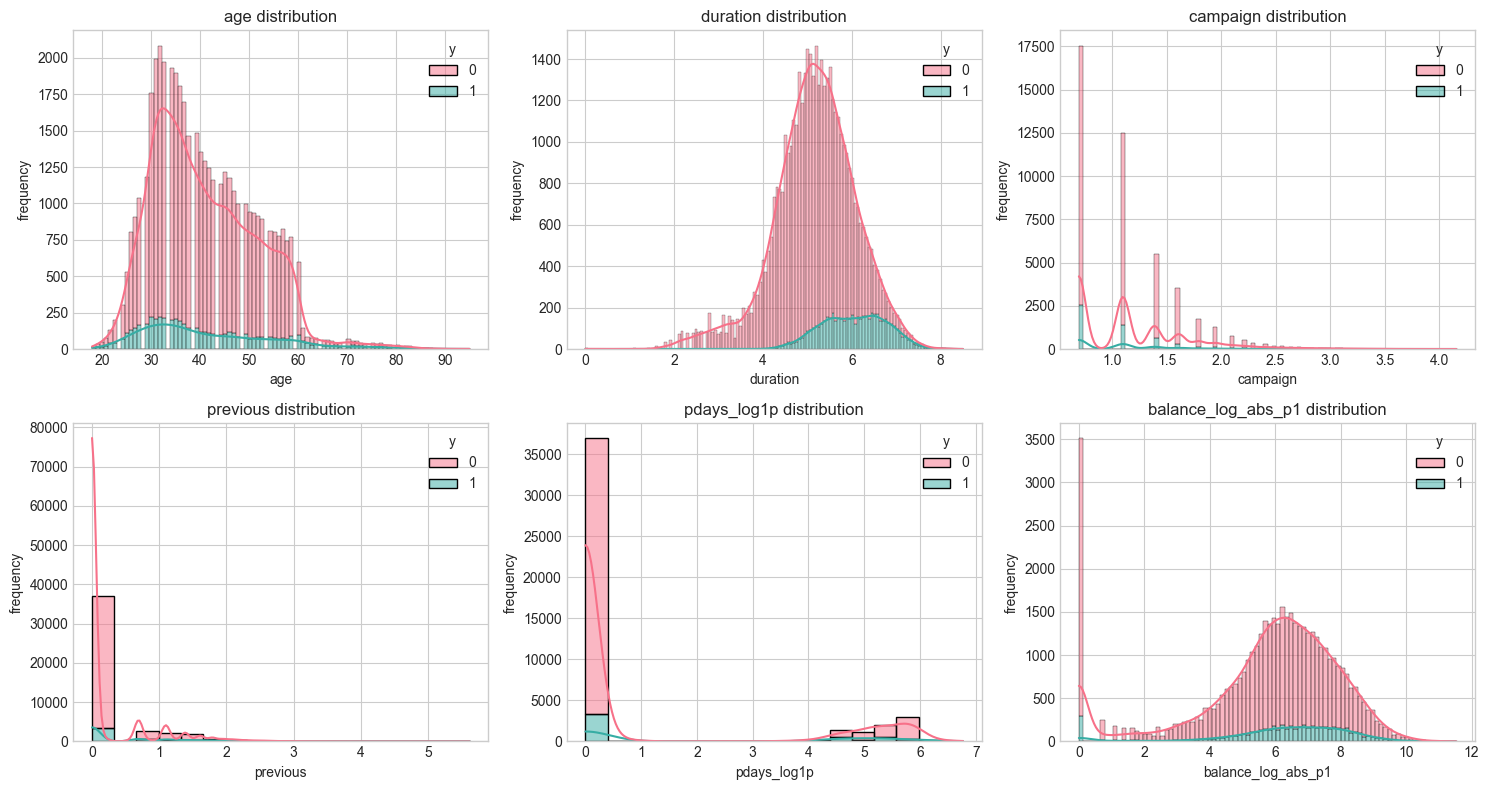

In [14]:
# 对于数值特征，绘制分布图，创建一个3列的画布依次排列
num_features = len(numerical_features_updated)
num_rows = (num_features + 2) // 3  # 向上取整，确保有足够的行

# 创建子图
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))
axes = axes.flatten()  # 将多维数组展平为一维

# 为每个数值特征绘制分布图
for i, feature in enumerate(numerical_features_updated):
    ax = axes[i]
    # 绘制直方图和密度图
    sns.histplot(data=df,x=feature, hue='y',kde=True, ax=ax ,multiple="stack",palette="husl")
    ax.set_title(f'{feature} distribution')
    ax.set_xlabel(feature)
    ax.set_ylabel('frequency')

# 隐藏未使用的子图
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()